creating `windowed` datablocks using fastai.  The specified windows used as based on this [discussion](https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930). This kernel is purely looking at what the dicom images look like when using the 3 windows.

`lung` window:
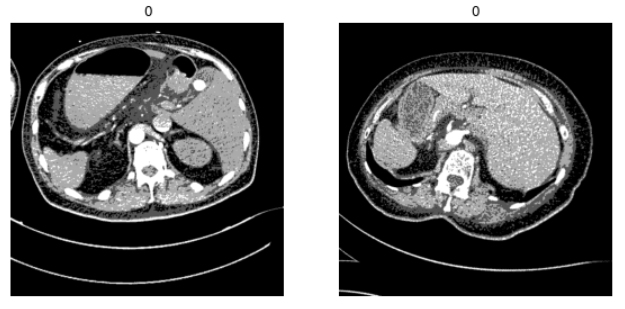

`PE` window:
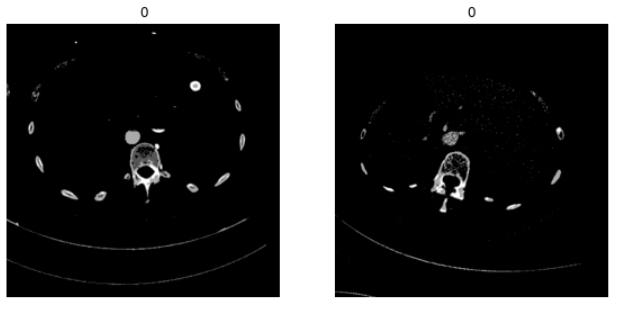

`Mediastinal` window
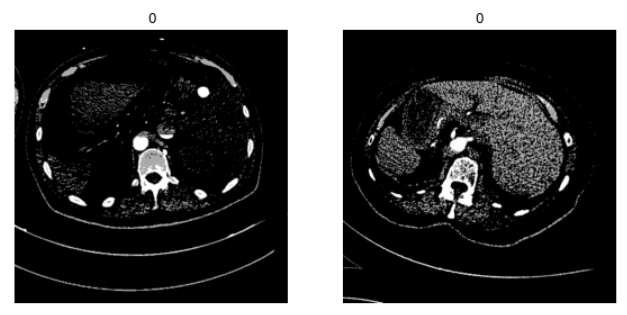

This version takes care of image inconsistencies found in previous versions

In [ ]:
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.medical.imaging import *

In [ ]:
source = '../input/rsna-str-pulmonary-embolism-detection'
files = os.listdir(source)
files

Load the `train.csv`

In [ ]:
df = pd.read_csv(f'{source}/train.csv')
df.head()

Specify the `x` and the `y` and the `blocks`. For the initial datablock I will use the default `PILDicom` class from `fastai`

In [ ]:
get_x = lambda x:f'{source}/train/{x.StudyInstanceUID}/{x.SeriesInstanceUID}/{x.SOPInstanceUID}.dcm'
get_y = ColReader('pe_present_on_image')

blocks = (ImageBlock(cls=PILDicom), CategoryBlock)

`set_seed` is an easy way in ensuring reproducibility

In [ ]:
set_seed(7)
pe = DataBlock(blocks=blocks,
                get_x=get_x,
                splitter=RandomSplitter(),
                item_tfms=[Resize(512)],
                get_y=get_y,
                batch_tfms=aug_transforms(size=512))

Lets have a look at how the images look in the `datablock` but we will use a smaller subset for testing

In [ ]:
dls = pe.dataloaders(df[:1000], bs=16, n_workers=0)
dls.show_batch(max_n=4, nrows=1, ncols=4, figsize=(20,20))

Out of the box the images do not look too good! I am going to make a few adjustments to `PILDicom` and use `fastai`s in built functionality of scaling pixels.  You can find out more about the `fastai.medical.imaging` module [here](https://github.com/fastai/fastai/blob/master/nbs/60_medical.imaging.ipynb)

### PILDicom customization

The great thing about `fastai` is that it is highly customizable.  Here we create 3 window dicom classes to represent the 3 windows, `lung`, `pe` and `medistinal`

Lung window level=-600, width=1500

In [ ]:
class LungWindow(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        if isinstance(fn,bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): im = dcmread(fn)
        scaled = np.array(im.windowed(l=-600, w=1500).numpy())*255
        scaled = scaled.astype(np.uint8)
        return cls(Image.fromarray(scaled))

PE window level=100, width=700

In [ ]:
class PEWindow(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        if isinstance(fn,bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): im = dcmread(fn)
        scaled = np.array(im.windowed(l=100, w=700).numpy())*255
        scaled = scaled.astype(np.uint8)
        return cls(Image.fromarray(scaled))

Medistinal window level=40, width=400

In [ ]:
class MedistinalWindow(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        if isinstance(fn,bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): im = dcmread(fn)
        scaled = np.array(im.windowed(l=40, w=400).numpy())*255
        scaled = scaled.astype(np.uint8)
        return cls(Image.fromarray(scaled))

Having a look at the images with the customization

### Lung

In [ ]:
set_seed(7)
lung = DataBlock(blocks=(ImageBlock(cls=LungWindow), CategoryBlock),
                get_x=get_x,
                splitter=RandomSplitter(),
                item_tfms=[Resize(512)],
                get_y=get_y,
                batch_tfms=aug_transforms(size=512))

dls = lung.dataloaders(df[:1000], bs=16, n_workers=0)
dls.show_batch(max_n=4, nrows=1, ncols=4, figsize=(20,20))

### PE

In [ ]:
set_seed(7)
pew = DataBlock(blocks=(ImageBlock(cls=PEWindow), CategoryBlock),
                get_x=get_x,
                splitter=RandomSplitter(),
                item_tfms=[Resize(512)],
                get_y=get_y,
                batch_tfms=aug_transforms(size=512))

dls = pew.dataloaders(df[:1000], bs=16, n_workers=0)
dls.show_batch(max_n=4, nrows=1, ncols=4, figsize=(20,20))

### Medistinal

In [ ]:
set_seed(7)
med = DataBlock(blocks=(ImageBlock(cls=MedistinalWindow), CategoryBlock),
                get_x=get_x,
                splitter=RandomSplitter(),
                item_tfms=[Resize(512)],
                get_y=get_y,
                batch_tfms=aug_transforms(size=512))

dls = med.dataloaders(df[:1000], bs=16, n_workers=0)
dls.show_batch(max_n=4, nrows=1, ncols=4, figsize=(20,20))

### Combining the Windows in a `DataBlock`

In [ ]:
blocks = (
          ImageBlock(cls=LungWindow),
          ImageBlock(cls=PEWindow),
          ImageBlock(cls=MedistinalWindow),
          CategoryBlock

          )

getters = [
          get_x,
          get_x,
          get_x,
          ColReader('pe_present_on_image')
          ]

multiimage = DataBlock(blocks=blocks,
              getters=getters,
              item_tfms=Resize(256),
              batch_tfms=aug_transforms(size=256)
              )

`summary` is a cool function you can use to see how the batches are collated in `fastai` or for catching any issues there may be in the `DataBlock`

In [ ]:
multiimage.summary(df[:1000])

In [ ]:
dls = multiimage.dataloaders(df[:1000], bs=16)
dls.show_batch(max_n=8, figsize=(7,7))